In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import datetime

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import pickle

In [2]:
print(tf. __version__)

2.6.2


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## TensorBoard

In [4]:
# log_directory = 'logs\\fit_' + datetime.datetime.now().strftime("%Y-%m-%d--%H-%M")
# board = TensorBoard(log_dir=log_directory,histogram_freq=1,
#     write_graph=True,
#     write_images=True,
#     update_freq='epoch',
#     profile_batch=2,
#     embeddings_freq=1)

In [5]:
# pwd

tensorboard --logdir logs\fit 

http://localhost:6006/#scalars

## Import Dataset

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [6]:
data_dir = 'C:\\Users\\andre\\Documents\\Datasets\\flower_photos'

In [7]:
image_count = 0
class_names = []
for i in os.scandir(data_dir):
    if i.is_dir():
        print(f'La carpeta {i.name} tiene {len(os.listdir(i))} imagenes')
        image_count += len(os.listdir(i))
        class_names.append(i.name)
        
print('------------')
print(f'El total de imagenes es {image_count}')

La carpeta daisy tiene 633 imagenes
La carpeta dandelion tiene 898 imagenes
La carpeta roses tiene 641 imagenes
La carpeta sunflowers tiene 699 imagenes
La carpeta tulips tiene 799 imagenes
------------
El total de imagenes es 3670


In [8]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [46]:
daisy = os.listdir(data_dir+'/daisy')
daisy = [data_dir + '/daisy/' + flower for flower in daisy] 

dandelion = os.listdir(data_dir+'/dandelion')
dandelion = [data_dir + '/dandelion/' + flower for flower in dandelion] 

roses = os.listdir(data_dir+'/roses')
roses = [data_dir + '/roses/' + flower for flower in roses] 

sunflowers = os.listdir(data_dir+'/sunflowers')
sunflowers = [data_dir + '/sunflowers/' + flower for flower in sunflowers] 

tulips = os.listdir(data_dir+'/tulips')
tulips = [data_dir + '/tulips/' + flower for flower in tulips] 

In [47]:
imread(roses[0]).shape

(240, 179, 3)

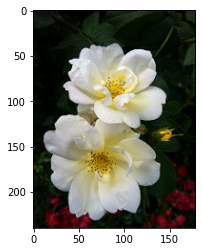

In [48]:
plt.imshow(imread(roses[0]))

# Data Pre-processing

## Finding the best shape

In [12]:
counter = 0
dim1 = []
dim2 = []
colors_temp = []
for i in os.scandir(data_dir):
    if i.is_dir():
        actual = os.listdir(data_dir+'/' + i.name)
        for j in actual:
            counter +=1
            img = imread(data_dir + '/' + i.name + '/' + j)
            d1,d2,colors = img.shape
            dim1.append(d1)
            dim2.append(d2)
            colors_temp.append(colors)
            

In [13]:
print(counter)
print(np.array(dim1).mean())
print(np.array(dim2).mean())
print(pd.Series(colors_temp).unique())

3670
271.79128065395093
365.0623978201635
[3]


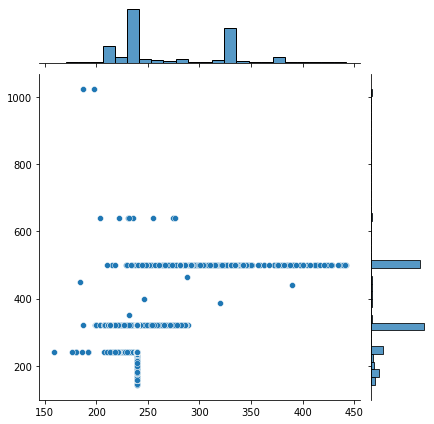

In [14]:
sns.jointplot(x = dim1,y = dim2)

In [39]:
batch_size = 32
img_height = 180
img_width = 180

# Explicit Dataset

In [15]:
list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [16]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\andre\\Documents\\Datasets\\flower_photos\\tulips\\8454719295_4276c0e9c5_n.jpg'
b'C:\\Users\\andre\\Documents\\Datasets\\flower_photos\\tulips\\5691672942_70a93d70fc.jpg'
b'C:\\Users\\andre\\Documents\\Datasets\\flower_photos\\roses\\9300754115_dd79670066_n.jpg'
b'C:\\Users\\andre\\Documents\\Datasets\\flower_photos\\roses\\5529341024_0c35f2657d.jpg'
b'C:\\Users\\andre\\Documents\\Datasets\\flower_photos\\tulips\\3909355648_42cb3a5e09_n.jpg'


In [17]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [23]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [33]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [34]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [35]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [68]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [69]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

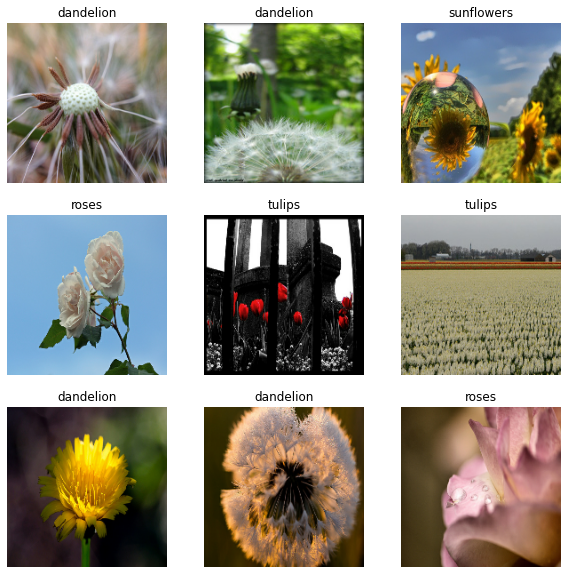

In [70]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [71]:
num_classes = 5

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Rescaling(1./255))
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes))

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [72]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200
)

Epoch 1/200
92/92 [==============================] - 18s 98ms/step - loss: 1.2689 - accuracy: 0.4527 - val_loss: 1.1269 - val_accuracy: 0.5654
Epoch 2/200
92/92 [==============================] - 6s 66ms/step - loss: 0.9742 - accuracy: 0.6141 - val_loss: 0.9252 - val_accuracy: 0.6594
Epoch 3/200
92/92 [==============================] - 6s 67ms/step - loss: 0.7794 - accuracy: 0.7057 - val_loss: 0.9719 - val_accuracy: 0.6308
Epoch 4/200
92/92 [==============================] - 6s 66ms/step - loss: 0.6121 - accuracy: 0.7663 - val_loss: 0.8558 - val_accuracy: 0.6866
Epoch 5/200
92/92 [==============================] - 6s 66ms/step - loss: 0.4539 - accuracy: 0.8345 - val_loss: 0.9690 - val_accuracy: 0.6608
Epoch 6/200
92/92 [==============================] - 6s 66ms/step - loss: 0.2754 - accuracy: 0.9087 - val_loss: 1.1212 - val_accuracy: 0.6717
Epoch 7/200
92/92 [==============================] - 6s 66ms/step - loss: 0.1799 - accuracy: 0.9428 - val_loss: 1.3191 - val_accuracy: 0.6540
Epoch

92/92 [==============================] - 6s 65ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 2.7585 - val_accuracy: 0.6839
Epoch 59/200
92/92 [==============================] - 6s 66ms/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 2.7641 - val_accuracy: 0.6812
Epoch 60/200
92/92 [==============================] - 6s 65ms/step - loss: 9.5837e-04 - accuracy: 0.9997 - val_loss: 2.7938 - val_accuracy: 0.6771
Epoch 61/200
92/92 [==============================] - 6s 65ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 2.8054 - val_accuracy: 0.6853
Epoch 62/200
92/92 [==============================] - 8s 87ms/step - loss: 0.0010 - accuracy: 0.9993 - val_loss: 2.8251 - val_accuracy: 0.6812
Epoch 63/200
92/92 [==============================] - 6s 65ms/step - loss: 0.0010 - accuracy: 0.9993 - val_loss: 2.8456 - val_accuracy: 0.6839
Epoch 64/200
92/92 [==============================] - 6s 65ms/step - loss: 8.9295e-04 - accuracy: 0.9993 - val_loss: 2.8659 - val_accuracy: 0.6812
Epoc

Epoch 114/200
92/92 [==============================] - 6s 65ms/step - loss: 0.1352 - accuracy: 0.9574 - val_loss: 2.2271 - val_accuracy: 0.6199
Epoch 115/200
92/92 [==============================] - 6s 65ms/step - loss: 0.0599 - accuracy: 0.9823 - val_loss: 2.7611 - val_accuracy: 0.6390
Epoch 116/200
92/92 [==============================] - 6s 65ms/step - loss: 0.0189 - accuracy: 0.9969 - val_loss: 2.4200 - val_accuracy: 0.6485
Epoch 117/200
92/92 [==============================] - 8s 86ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 2.6095 - val_accuracy: 0.6526
Epoch 118/200
92/92 [==============================] - 6s 65ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 2.7308 - val_accuracy: 0.6526
Epoch 119/200
92/92 [==============================] - 6s 65ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 2.8108 - val_accuracy: 0.6458
Epoch 120/200
92/92 [==============================] - 6s 66ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 2.8726 - val_accuracy:

Epoch 170/200
92/92 [==============================] - 6s 65ms/step - loss: 8.0510e-04 - accuracy: 0.9993 - val_loss: 2.9585 - val_accuracy: 0.6417
Epoch 171/200
92/92 [==============================] - 6s 65ms/step - loss: 7.2519e-04 - accuracy: 0.9993 - val_loss: 3.0018 - val_accuracy: 0.6471
Epoch 172/200
92/92 [==============================] - 6s 65ms/step - loss: 6.4810e-04 - accuracy: 0.9993 - val_loss: 3.0360 - val_accuracy: 0.6458
Epoch 173/200
92/92 [==============================] - 8s 69ms/step - loss: 6.5229e-04 - accuracy: 0.9993 - val_loss: 3.0674 - val_accuracy: 0.6458
Epoch 174/200
92/92 [==============================] - 6s 66ms/step - loss: 5.5122e-04 - accuracy: 0.9997 - val_loss: 3.0882 - val_accuracy: 0.6458
Epoch 175/200
92/92 [==============================] - 6s 66ms/step - loss: 6.2529e-04 - accuracy: 0.9993 - val_loss: 3.1030 - val_accuracy: 0.6471
Epoch 176/200
92/92 [==============================] - 6s 65ms/step - loss: 5.8087e-04 - accuracy: 0.9993 - val_

## Train/Test Split

In [ ]:
## Cambiarlo al promedio
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
## Experimento para hacer lo mismo de arriba en un solo paso
# train_ds_e, val_ds_e = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="both",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)


In [ ]:
class_names = train_ds.class_names
print(class_names)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

## Creating the Normalization Layer

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

In [ ]:
num_classes = 5

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Rescaling(1./255))
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes))

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=600, 
    use_multiprocessing = True
)

## Evaluation

In [ ]:
model.history.history

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
model.metrics_names

In [ ]:
training_score = model.evaluate(X_train,y_train,verbose=0)
test_score = model.evaluate(X_test,y_test,verbose=0)

In [ ]:
print(training_score)
print(test_score)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions.head()